# *Image processing of corroded pit - part 2: analysis of crystal sediments*

- By [Gianluca Iori](https://github.com/gianthk), Giulia Franceschin, Roberta Zanin, Elena Longo, 2022
- Code licence: MIT
- Narrative licence: CC-BY 
- How to cite: *Specify how you want people to cite this notebook. You can refer to a publication or a repository (e.g. link your GitHub repository to Zenodo - see [this video](https://www.youtube.com/watch?v=gp3D4mf6MHQ))*
- Created on:  22.04.2022
- Last update: 22.02.2023

---
# Aims
Generate triangle mesh of one crystal deposit

Figure 6. 3D orientation of secondary phases. (a) Orientation distribution plot of the grain principal axis. (b) 3D rendering of one secondary phase grain, with principal axis (eigenvector) shown in green. (c-e) Orthogonal sections through the analysed pit. Principal axes of secondary grains shown as line overlay coloured according to their orientation with respect to the image X-axis. Tick bars: 500 µm. 3D rendering showing the correlation between voids (in blue) and crystalline phases (in yellow) distributionsorientation of crystalline phases. ---
# *Computational workflow*

## Configuration and imports

In [28]:
import sys
sys.path.append('./../../recon_utils')
sys.path.append('./../../../recon_utils')
# sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

Configure working folder (change this to your local path)

In [29]:
# work_folder = "/run/media/beats/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt"
# work_folder = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'
work_folder = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'

In [30]:
import numpy as np
import meshio
import mcubes
from recon_utils import read_tiff_stack, plot_midplanes

import spam.mesh
import spam.label
import spam.plotting
import spam.datasets

Matplotlib plotting configuration

## Load crystal mask

In [31]:
input_file = work_folder+'/masks/crystal2/slice_00.tif'

In [37]:
crystal_BW = read_tiff_stack(input_file)

Voxelsize:

In [38]:
vs = np.ones(3)*1.0e-3 # [mm]

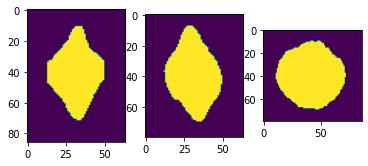

In [39]:
# Inspect slice
plot_midplanes(crystal_BW)

## Compute outer mesh of triangles

In [42]:
vertices, triangles = mcubes.marching_cubes(np.transpose(mcubes.smooth(crystal_BW>=1), [2, 1, 0]), 0)

## Save the mesh
write VTK mesh with meshio

In [43]:
filename_mesh_out = work_folder+'/masks/crystal2.vtk'
meshio.write_points_cells(filename_mesh_out, vertices.tolist(), [("triangle", triangles.tolist())])

![1crystal](crystal.png)

### Compute particle bounding box

In [44]:
boundingBoxes = spam.label.boundingBoxes(crystal_BW>=1)

### Compute particles centres of mass

In [45]:
centresOfMass = spam.label.centresOfMass(crystal_BW>=1, boundingBoxes=boundingBoxes) # Z,Y,X

### Particle orientation
We use the `Moments of Inertia` method of the `spam.label` toolkit.

In [46]:
MOIeigenValues, MOIeigenVectors = spam.label.momentOfInertia(crystal_BW>=1, boundingBoxes=boundingBoxes, centresOfMass=centresOfMass)

### Radii of the ellipsoid fitting the particle
We use the `ellipseAxes` method of `spam.label`.

In [47]:
ellipseDimensions = spam.label.ellipseAxes(crystal_BW>=1, volumes=spam.label.volumes(crystal_BW>=1), MOIeigenValues=MOIeigenValues)

### Save vector filed data of particle orientation
We use `meshio` to save an `unstructured grid` `VTK` file containing the coordinates of each particle's center of mass and its orientation vector.

The coordinates [x,y,z] of the particle's center of mass are stored in the array: `centresOfMass[1:, [2, 1, 0]]`.
The particle's orientation vector [x,y,z] is in `MOIeigenVectors[1:, [8, 7, 6]]`.

In [49]:
filename_mesh_out = work_folder+'/masks/crystal2_MOIeigenVectors.vtk'
meshio.write_points_cells(filename_mesh_out,
                          centresOfMass[1:, [2, 1, 0]]/2, [],
                          point_data={"MOIeigenVector1": MOIeigenVectors[1:, [2, 1, 0]],
                                      "MOIeigenVector2": MOIeigenVectors[1:, [5, 4, 3]],
                                      "MOIeigenVector3": MOIeigenVectors[1:, [8, 7, 6]]})

---
# Acknowledgements
-  The authors acknowledge the [CERIC-ERIC](https://www.ceric-eric.eu/) Consortium for the access to experimental facilities and financial support